# HW-2 IST 707 Data Analytics (Abhiraj Singh)

# Import relevant libraries

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer as Imputer
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import tree
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import ward, dendrogram
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as metrics

In [3]:
df = pd.read_csv('Weather Forecast Training.csv')
df_test = pd.read_csv('Weather Forecast Testing.csv')
print("Shape of the Dataset is", df.shape)
df.head(5)

Shape of the Dataset is (51978, 16)


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Cloud,Temp,RainToday,RainTomorrow
0,NorahHead,18.9,23.7,0.0,NaN,NaN,SSE,41.0,SSE,28.0,55.0,1026.0,NaN,22.4,No,Yes
1,Nuriootpa,11.1,20.8,0.0,4.8,8.3,W,39.0,WSW,26.0,48.0,1014.4,7.0,19.5,No,No
2,GoldCoast,15.9,19.5,17.6,NaN,NaN,SE,44.0,SW,9.0,99.0,1028.5,NaN,17.8,Yes,Yes
3,Bendigo,0.0,14.9,0.0,NaN,NaN,WSW,35.0,WNW,19.0,55.0,1023.0,4.0,14.2,No,Yes
4,Walpole,9.1,22.7,0.0,NaN,NaN,NNE,41.0,ESE,7.0,40.0,1027.1,NaN,22.5,No,No


In [147]:
print("The total values as Yes in the target variable: ",len(df[df['RainTomorrow']=='Yes']))
print("The total values as No in the target variable: ",len(df[df['RainTomorrow']=='No']))
print("The dataset can be considered as balanced dataset")

The total values as Yes in the target variable:  25519
The total values as No in the target variable:  26459
The dataset can be considered as balanced dataset


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MinTemp,51694.0,12.549174,6.376746,-8.0,7.9,12.3,17.2,31.4
MaxTemp,51849.0,22.512698,7.113064,-4.1,17.2,21.8,27.5,47.0
Rainfall,51231.0,3.639494,11.009628,0.0,0.0,0.0,2.2,371.0
Evaporation,29425.0,5.177570,4.017662,0.0,2.4,4.4,7.0,77.3
Sunshine,27103.0,6.530580,3.946561,0.0,3.2,6.9,9.9,14.5
WindGustSpeed,48407.0,42.003016,14.627024,7.0,31.0,39.0,50.0,135.0
WindSpeed,50954.0,19.092299,9.157505,0.0,13.0,19.0,24.0,83.0
Humidity,50549.0,57.432214,21.833045,1.0,42.0,58.0,73.0,100.0
Pressure,46912.0,1014.273338,7.278733,977.1,1009.3,1014.2,1019.2,1037.8
Cloud,31848.0,5.175647,2.632166,0.0,3.0,6.0,7.0,8.0


In [5]:
print('The datatype of the features are:', df.dtypes)
print('***********************************')
df.isna().sum()

The datatype of the features are: Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir           object
WindSpeed        float64
Humidity         float64
Pressure         float64
Cloud            float64
Temp             float64
RainToday         object
RainTomorrow      object
dtype: object
***********************************


Location             0
MinTemp            284
MaxTemp            129
Rainfall           747
Evaporation      22553
Sunshine         24875
WindGustDir       3598
WindGustSpeed     3571
WindDir           1513
WindSpeed         1024
Humidity          1429
Pressure          5066
Cloud            20130
Temp              1063
RainToday          747
RainTomorrow         0
dtype: int64

# Data Preprocessing

In this section we will implement the data cleaning methods which will help us impute the values which are missing. Since we know that the columns 'Sunshine', 'Evaporation', 'Cloud' have plenty of data as missing, therefore it should be imputed. We try to avoid the loss of data points. So here we imputed the missing values of the mentioned columns by the average values. Where we have the RainToday as Yes and No we take the average of 'Sunshine', 'Evaporation', 'Cloud' with Yes and No respectively. Now we impute the values using the above technique for 'Sunshine', 'Evaporation', 'Cloud' columns. This imputation is better understood by code.

In [6]:
lst = ['Sunshine', 'Evaporation', 'Cloud']
def na_replace(lst,df,dforig):
  for col in lst: 
    if df['RainToday'].all() == 'Yes':
      df[col]=df[col].fillna(dforig[col][dforig['RainToday']=='Yes'].mean())
    else:
      df[col]=df[col].fillna(dforig[col][dforig['RainToday']=='No'].mean()) 
  return df

In [7]:
df_train=na_replace(lst, df,df)
df_test = na_replace(lst,df_test,df)

Impute the NA value with average where we have data type as numerical and replace the NA of object data type with mode.
Reason: Since the below mentioned columns have less number of missing data points therefore we impute the NA of non-object type with mean and object type (i.e. categorical variable) with their modes respectively.

In [8]:
lst_1000 = ['MinTemp','MaxTemp','Rainfall','WindGustDir','WindGustSpeed','WindDir','WindSpeed','Humidity','Pressure','Cloud','Temp','RainToday']

def na_values2(col, df, dforig):
  for col in lst_1000:
    if df[col].dtypes != 'object':
      df[col]=df[col].fillna(dforig[col].mean())
    else:
      na_mode = dforig[col].mode()[0]
      df[col]=df[col].fillna(na_mode)
  return df

In [9]:
#imputation on the training and test dataset
df_train=na_values2(lst_1000,df_train,df)
df_test = na_values2(lst_1000,df_test,df)

In [10]:
print(df_train.dtypes)
print('*****************************')
df_train.isna().sum()

Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir           object
WindSpeed        float64
Humidity         float64
Pressure         float64
Cloud            float64
Temp             float64
RainToday         object
RainTomorrow      object
dtype: object
*****************************


Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir          0
WindSpeed        0
Humidity         0
Pressure         0
Cloud            0
Temp             0
RainToday        0
RainTomorrow     0
dtype: int64

Drop the columns with object as datatype

In [11]:
df_train = df_train.drop(columns=['RainToday', 'WindDir','WindGustDir','Location'])
df_train.dtypes
df_test = df_test.drop(columns=['ID','RainToday', 'WindDir','WindGustDir','Location'])
df_test.dtypes

MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustSpeed    float64
WindSpeed        float64
Humidity         float64
Pressure         float64
Cloud            float64
Temp             float64
dtype: object

In [113]:
#Replace the target variable as 1 and 0 for yes and no respectively
def target_variable(df,col):
  for i in df[col]:
    if i == 'Yes':
      df[col] = df[col].replace('Yes', 1)
    else:
      df[col] = df[col].replace('No', 0)
  return df 

  

In [13]:
df_train=target_variable(df_train,'RainTomorrow')
df_train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed,Humidity,Pressure,Cloud,Temp,RainTomorrow
0,18.9,23.7,0.0,5.711067,7.454335,41.000000,28.0,55.0,1026.0,4.660967,22.4,1
1,11.1,20.8,0.0,4.800000,8.300000,39.000000,26.0,48.0,1014.4,7.000000,19.5,0
2,15.9,19.5,17.6,5.711067,7.454335,44.000000,9.0,99.0,1028.5,4.660967,17.8,1
3,0.0,14.9,0.0,5.711067,7.454335,35.000000,19.0,55.0,1023.0,4.000000,14.2,1
4,9.1,22.7,0.0,5.711067,7.454335,41.000000,7.0,40.0,1027.1,4.660967,22.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...
51973,20.1,25.8,5.6,4.400000,8.200000,28.000000,13.0,72.0,1018.9,3.000000,24.7,1
51974,14.2,18.6,2.8,4.000000,0.000000,41.000000,20.0,52.0,1022.3,4.660967,17.2,1
51975,11.1,17.2,1.2,5.711067,7.454335,31.000000,11.0,92.0,1018.7,4.660967,12.9,1
51976,19.0,24.8,0.0,5.200000,7.500000,42.003016,17.0,65.0,1015.4,7.000000,23.4,0


In [14]:
df_train['RainTomorrow']= df_train['RainTomorrow'].astype(str).astype(int)

In [15]:
X, y = df_train.drop(columns=['RainTomorrow']) , df_train['RainTomorrow']

# MinMaxScaler

Standardization of the dataset using the minmaxscaler. We do this standardization/scaling to bring all the features in a scale which is mandatory for clustering algorithms to work more effectively. Also, minmaxscaler is helpful to preserve the shape of the original distribution without changing the information present the data. 

In [16]:
min_max_scaler = preprocessing.MinMaxScaler()

#Normalizing the test data
df_normalized_test = min_max_scaler.fit_transform(df_test)
df_normalized_test = pd.DataFrame(df_normalized_test, columns=df_test.columns, index=df_test.index)
df_normalized_test

#Normalizing the train data
df_normalized_train = min_max_scaler.fit_transform(X)
df_normalized_train = pd.DataFrame(df_normalized_train, columns=X.columns, index=X.index)
df_normalized_train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed,Humidity,Pressure,Cloud,Temp
0,0.682741,0.544031,0.000000,0.073882,0.514092,0.265625,0.337349,0.545455,0.805601,0.582621,0.530693
1,0.484772,0.487280,0.000000,0.062096,0.572414,0.250000,0.313253,0.474747,0.614498,0.875000,0.473267
2,0.606599,0.461840,0.047439,0.073882,0.514092,0.289062,0.108434,0.989899,0.846787,0.582621,0.439604
3,0.203046,0.371820,0.000000,0.073882,0.514092,0.218750,0.228916,0.545455,0.756178,0.500000,0.368317
4,0.434010,0.524462,0.000000,0.073882,0.514092,0.265625,0.084337,0.393939,0.823723,0.582621,0.532673
...,...,...,...,...,...,...,...,...,...,...,...
51973,0.713198,0.585127,0.015094,0.056921,0.565517,0.164062,0.156627,0.717172,0.688633,0.375000,0.576238
51974,0.563452,0.444227,0.007547,0.051746,0.000000,0.265625,0.240964,0.515152,0.744646,0.582621,0.427723
51975,0.484772,0.416830,0.003235,0.073882,0.514092,0.187500,0.132530,0.919192,0.685338,0.582621,0.342574
51976,0.685279,0.565558,0.000000,0.067270,0.517241,0.273461,0.204819,0.646465,0.630972,0.875000,0.550495


# Splitting the dataset for trainning and validation

We perform train-test split in this section. We need training set to allow the machine learning learn patterns or gain information. Then test data is helpful to know how well our model performs on the unseen dataset. This allows us to see how well the model is able to generalize. This is a crucial step to determine the performance of the model

In [17]:
#Splitting the non-normalized data
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2, random_state=0)


In [18]:
#splitting the normalized dataset
X_train_norm, X_val_norm, Y_train_norm, y_val_norm = train_test_split(df_normalized_train, y, test_size=0.2, random_state=0)


# kMEANS Base Model

working: The Kmeans algorithm follows a simple approach to generate effective results. The steps involved are: Decide the number of clusters, then we select K random points from the data as the centeroid. Assign the points to the nearest cluster centroid. Then Calculate the centroid of the newly formed clusters. Repeat the last two steps.

In this section we will implement the Kmeans algorithm by fitting the model to unscaled and scaled training dataset and access the performance on the val dataset. Finally we can see various evaluation metrics using the classification report. 

In [19]:
#fitting the non-normalized data to the base Kmeans model  
kmeans = KMeans(n_clusters=2, n_init=25, max_iter=100, random_state=2)
kmeans.fit(X_train)
kmeans.labels_

cfm = confusion_matrix(Y_train, kmeans.labels_)
print(cfm)
print('The accuracy of the model is: ',accuracy_score(kmeans.labels_, Y_train))

[[14021  7165]
 [ 4485 15911]]
The accuracy of the model is:  0.7198306959742196


In [20]:
#create a check for the labels
y_pred = kmeans.labels_
y_train = Y_train


In [21]:
#Classification report for the non-normalized to the base model

print(classification_report(Y_train, kmeans.labels_))

              precision    recall  f1-score   support

           0       0.76      0.66      0.71     21186
           1       0.69      0.78      0.73     20396

    accuracy                           0.72     41582
   macro avg       0.72      0.72      0.72     41582
weighted avg       0.72      0.72      0.72     41582



In [22]:
#fitting the normalized data to the base Kmeans model  
kmeans = KMeans(n_clusters=2, n_init=25, max_iter=100, random_state=2)
kmeans.fit(X_train_norm)
kmeans.labels_

cfm = confusion_matrix(Y_train_norm, kmeans.labels_)
print(cfm)
print('The accuracy of the model is: ',accuracy_score(kmeans.labels_, Y_train_norm))

[[13919  7267]
 [ 4598 15798]]
The accuracy of the model is:  0.7146601895050743


In [23]:
#Classification report for the normalized to the base model

print(classification_report(Y_train_norm, kmeans.labels_))

              precision    recall  f1-score   support

           0       0.75      0.66      0.70     21186
           1       0.68      0.77      0.73     20396

    accuracy                           0.71     41582
   macro avg       0.72      0.72      0.71     41582
weighted avg       0.72      0.71      0.71     41582



# Based on the above results we can continue with normalized model.

# kMEANS hypertuning parameters

The best model can acheived by trying various hyperparameters for the kmeans. This can be done with the help of the grid search, which allows us to implemenent several combinations for the hyperparameters. This is demonstrated in the below section.

In [24]:
#We can tune using the GridSearchCV
kmeans = KMeans(random_state=2)
tuned_parameters = [{'n_clusters': [2],
                     'max_iter': [100,300,700],
                    'n_init': [25]}]

grid_search = GridSearchCV(estimator = kmeans, param_grid = tuned_parameters, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_norm)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    3.3s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    3.8s finished


GridSearchCV(cv=3, estimator=KMeans(random_state=2), n_jobs=-1,
             param_grid=[{'max_iter': [100, 300, 700], 'n_clusters': [2],
                          'n_init': [25]}],
             verbose=2)

In [25]:
print(grid_search.best_params_)  #getting the best parameters

{'max_iter': 100, 'n_clusters': 2, 'n_init': 25}


The below table shows the best model, n_clusters is 2. The max_iter show us the total iterations we need to get the values of the centroid. n_init shows us number of time the k-means algorithm will be run with different centroid seeds.

In [133]:
#create a df for best parameters and it's metrics
ids_k = []
for i in range(0,1):
    ids_k.append(i)


kmean_table = {'id':ids_k,'max_iter': 100, 'n_clusters' : 2, 'n_init' : 25, 'Accuracy' : 0.71, 'Recall':0.77,'Precision':0.68}
kmean_table_df = pd.DataFrame(kmean_table)
kmean_table_df

,id,max_iter,n_clusters,n_init,Accuracy,Recall,Precision
0,0,100,2,25,0.71,0.77,0.68


# kMEANS BEST MODEL

Now implement the kMEANS using the best parameters

In [26]:
#flip the values in 2 clusters.
lst = []
def change_label():
  for i in kmeans.labels_:
    if i == 0:
      a = i.replace(0,1)
      lst.append(a)
    else:
      b = i.replace(1,0)
      lst.append(b)
  return lst

In [27]:
#fitting the normalized data to the base Kmeans model  
kmeans = KMeans(n_clusters=2, n_init=25, max_iter=100, random_state=2)
kmeans.fit(X_train_norm)

# cfm = confusion_matrix(Y_train_norm, kmeans.labels_)
# print(cfm)
print('The accuracy of the model is: ',accuracy_score(kmeans.labels_, Y_train_norm))

The accuracy of the model is:  0.7146601895050743


# Implement the best on the test dataset to get the labels

In [91]:
pred_kmeans = kmeans.predict(df_normalized_test)

In [92]:
pred_kmeans

array([1, 1, 0, ..., 1, 0, 0])

# Decision Tree Implementation: Base Model

We do not need the normalized data for decision tree. We can build the decision tree for classification and regression tasks. This algorithm basically breaks the dataset into a small subsets. The associated decision is the build simultaneously. We receive the final tree with decision nodes and leaf nodes based on the rules learned by the decision tree. 

In this section we will fit the training dataset into the decision tree classifier and allow the model to generate rules and gain information. Then evaluate the performance of the model on val dataset. Finally we built the classification report to see how the base model performs on the unseen dataset. We further implement grid serach to try other combinations of the hyperparameters to get the best model. Then implement the best model on the unseen dataset and test dataset to generate the output. 

In [30]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)
pred = clf.predict(X_val)

In [31]:
cfm = confusion_matrix(Y_val, pred)
print(cfm)
print('The accuracy of the model is: ',accuracy_score(pred, Y_val))
print(classification_report(pred, Y_val))

[[3802 1471]
 [1479 3644]]
The accuracy of the model is:  0.7162370142362448
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      5281
           1       0.71      0.71      0.71      5115

    accuracy                           0.72     10396
   macro avg       0.72      0.72      0.72     10396
weighted avg       0.72      0.72      0.72     10396



In [32]:
X_train.shape

(41582, 11)

# Decision Tree Hyperparameters Tuning

In [33]:
clf = tree.DecisionTreeClassifier()

tuned_parameters = {
              'min_samples_split': [2, 10, 20, 25,30,35],
              'max_depth': [4, 5, 6, 10, 15, 20,30],
              'min_samples_leaf': [ 1, 2 , 5, 10],
              'max_leaf_nodes': [2, 5, 10, 20,22,25]}
grid_search = GridSearchCV(estimator = clf, param_grid = tuned_parameters, cv = 3, n_jobs = -1)

grid_search.fit(X_train,Y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 10, 15, 20, 30],
                         'max_leaf_nodes': [2, 5, 10, 20, 22, 25],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 10, 20, 25, 30, 35]})

In [34]:
grid_search.best_params_

{'max_depth': 10,
 'max_leaf_nodes': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [35]:
print(classification_report(Y_val,pred))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      5273
           1       0.71      0.71      0.71      5123

    accuracy                           0.72     10396
   macro avg       0.72      0.72      0.72     10396
weighted avg       0.72      0.72      0.72     10396



# Decision Tree Best Model

In [36]:
clf = tree.DecisionTreeClassifier(max_depth= 10,max_leaf_nodes= 20,min_samples_leaf= 1,min_samples_split= 2)
clf = clf.fit(X_train, Y_train)
pred = clf.predict(X_val)

In [37]:
cfm = confusion_matrix(Y_val, pred.round())
print(cfm)
print('The accuracy of the model is: ',accuracy_score(pred.round(), Y_val))
print(classification_report(pred.round(), Y_val))

[[4125 1148]
 [1365 3758]]
The accuracy of the model is:  0.7582724124663333
              precision    recall  f1-score   support

           0       0.78      0.75      0.77      5490
           1       0.73      0.77      0.75      4906

    accuracy                           0.76     10396
   macro avg       0.76      0.76      0.76     10396
weighted avg       0.76      0.76      0.76     10396



In [135]:
#create a df for best parameters and it's metrics
ids_k = []
for i in range(0,1):
    ids_k.append(i)


dt_table = {'id':ids_k,'max_depth': 10, 'max_leaf_nodes' : 20, 'min_samples_leaf' : 1, 'min_samples_split':2, 'Accuracy' : 0.76,'Recall':0.77,'Precision':0.73}
dt_table_df = pd.DataFrame(dt_table)
dt_table_df

,id,max_depth,max_leaf_nodes,min_samples_leaf,min_samples_split,Accuracy,Recall,Precision
0,0,10,20,1,2,0.76,0.77,0.73


Hyperparameter tuning: MaxDepth as the name suggests, the maximum depth we allow the decision tree to grow until. This should not be too much as that may cause overfitting and the model will not be able to generalize the test dataset. Themin_samples_split tells us minimum number of samples required to split an internal node. The max_leaf_nodes basically provides best nodes are defined as relative reduction in impurity. The minimum number tells us about the samples required to be at a leaf node.

# Decision Tree Implementation on the test dataset

In [38]:
decision_tree = clf.predict(df_test)
decision_tree

array([1, 1, 0, ..., 1, 0, 1])

# AUC ROC Implementation

[[0.773358   0.226642  ]
 [0.0883021  0.9116979 ]
 [0.20169014 0.79830986]
 ...
 [0.8102981  0.1897019 ]
 [0.0883021  0.9116979 ]
 [0.27466368 0.72533632]]


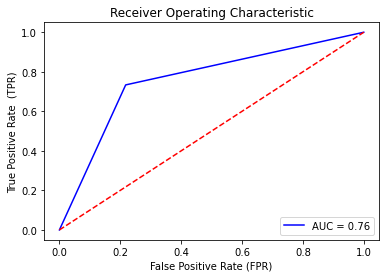

In [39]:
#Roc curve
#source https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html 
probs = clf.predict_proba(X_val)
preds = probs[:,1]
print(probs)
preds
fpr, tpr, threshold = metrics.roc_curve(Y_val, pred)

roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate  (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.show()

# Analysis of the decision tree model

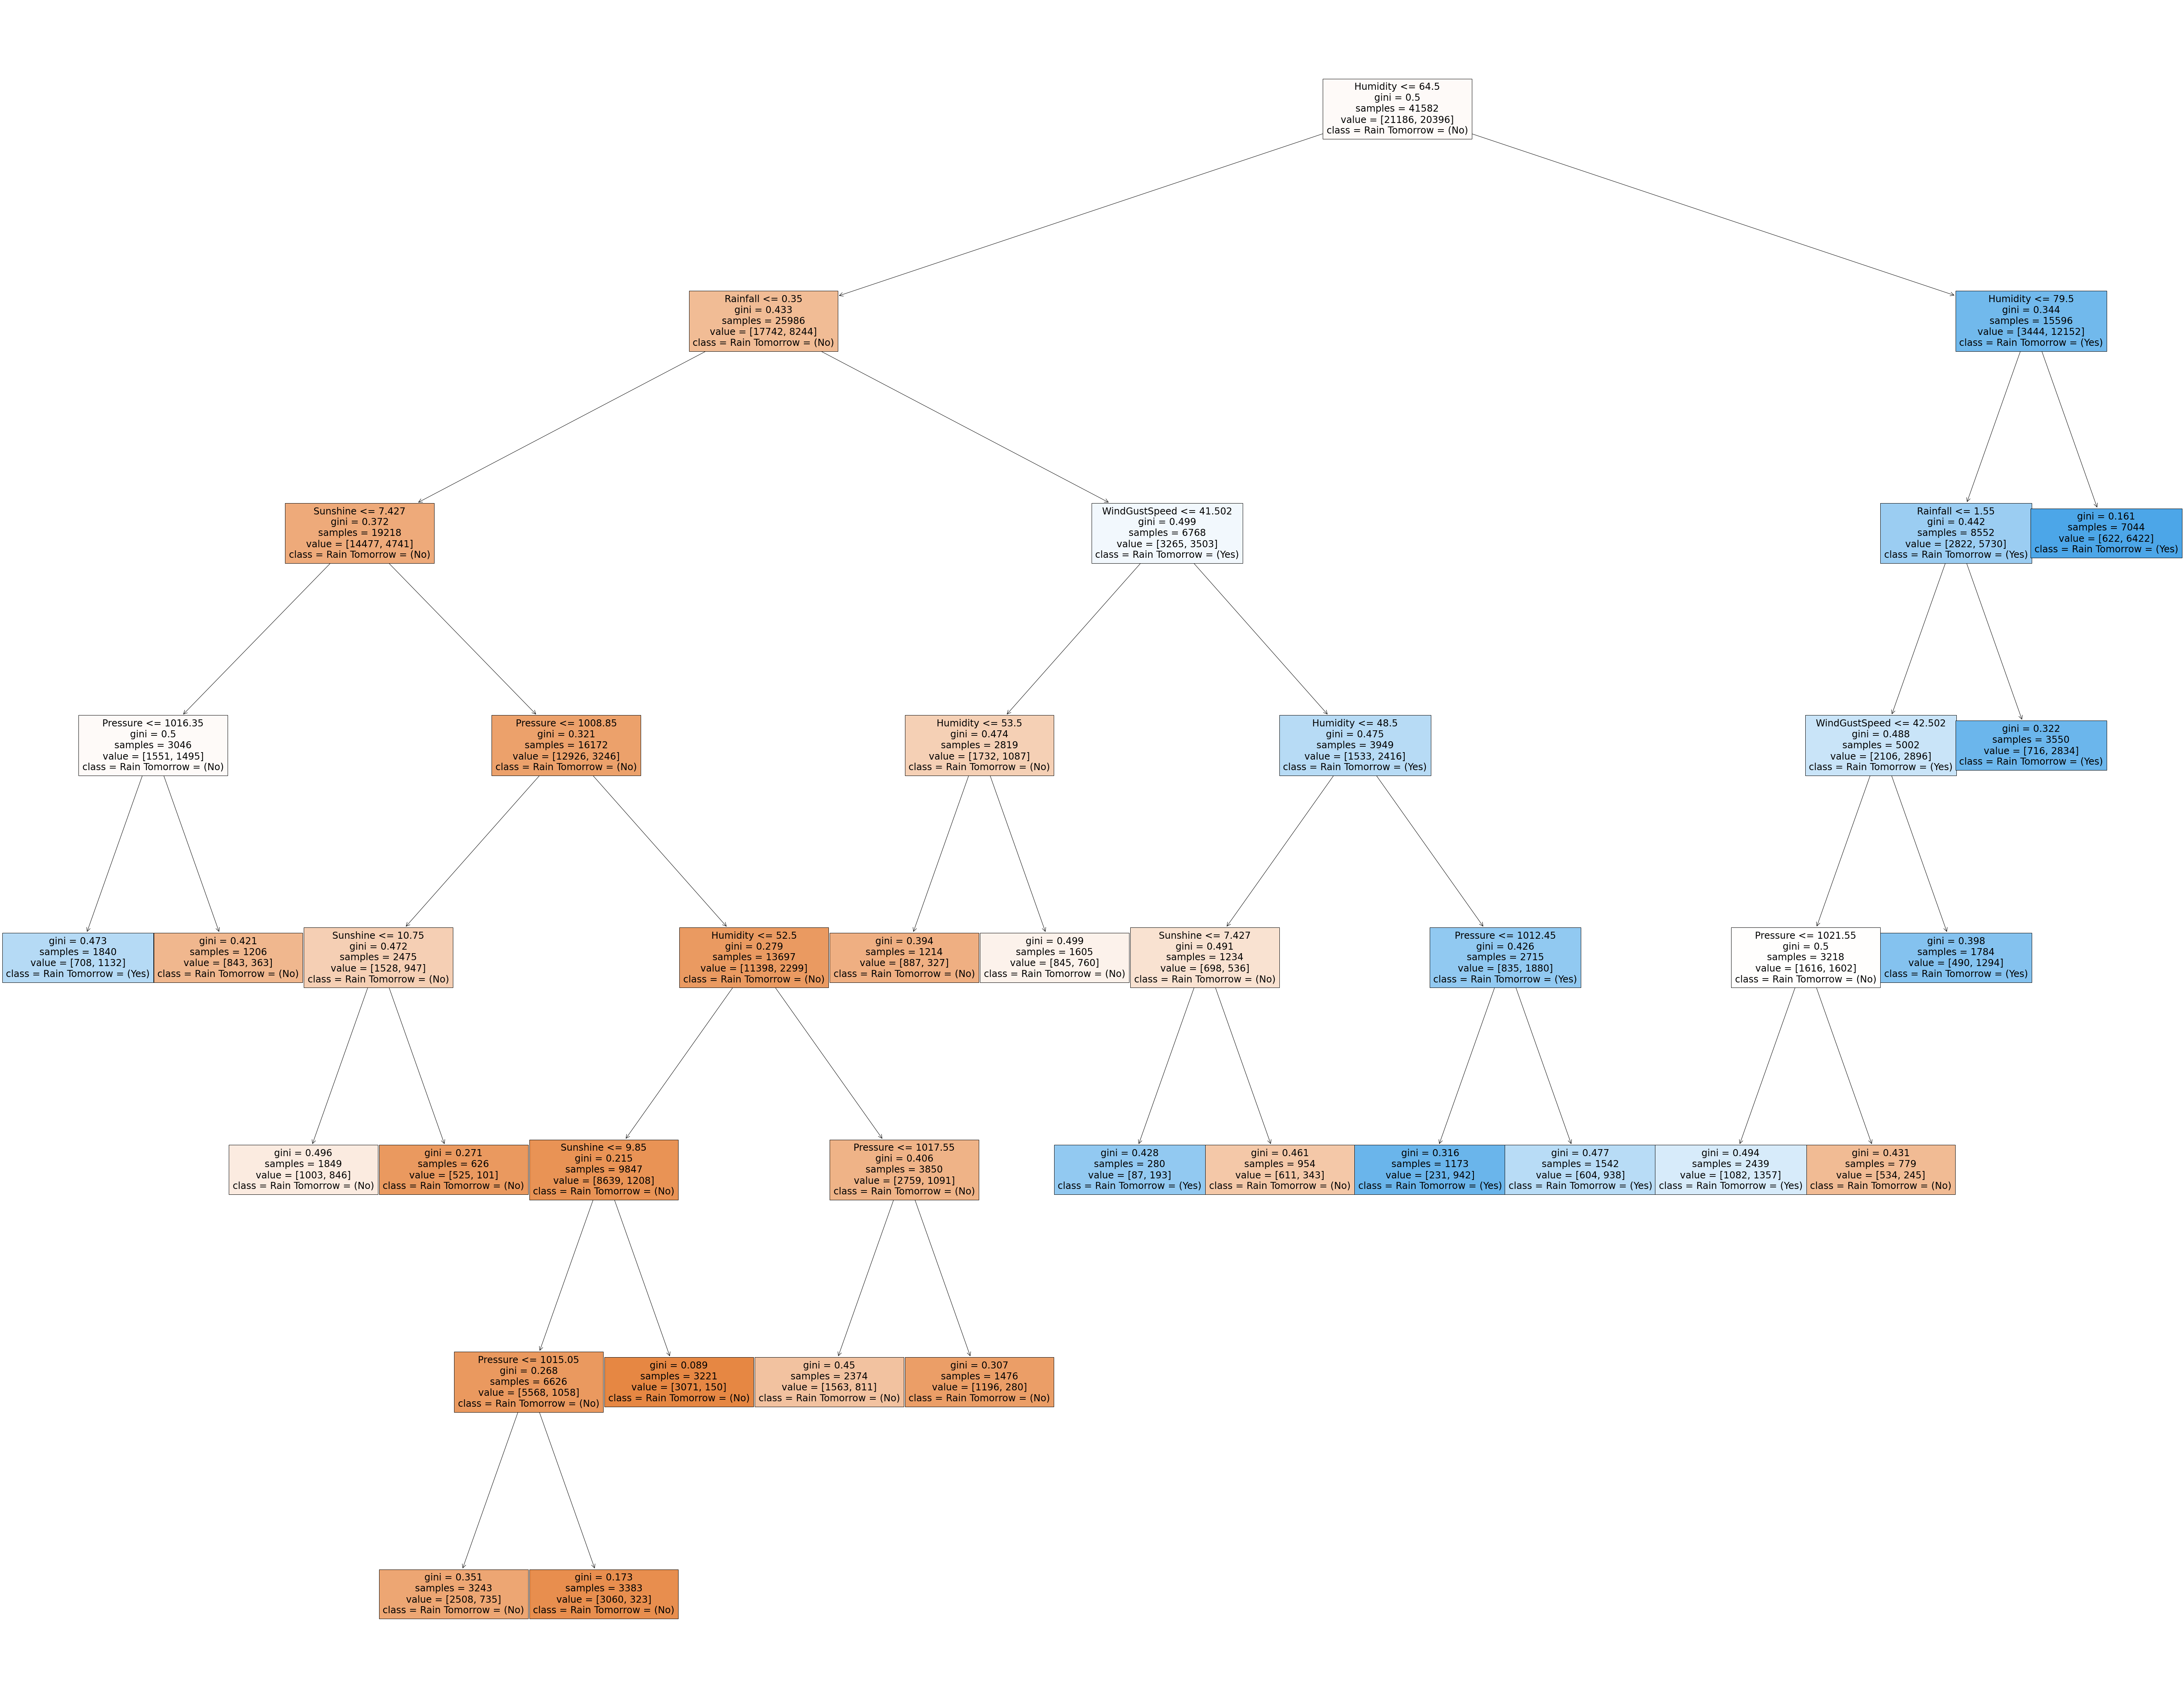

In [40]:
#source https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html

plt.figure(figsize = (100,80))
tree.plot_tree(clf,filled = True,feature_names=X_train.columns,class_names=['Rain Tomorrow = (No)','Rain Tomorrow = (Yes)'])
plt.show()

Interpretation of the above figure. Lets consider the parent node. The parent node is supposed to be the best feature on which the split takes place. The ultimate goal is to achieve the homogenous split. The above figure has humidity as the first node. This node is supposed to have the maximum gini and minimum entrophy. Since we considered gini as the criterion for building the decision tree therefore we can see that the first node has the best gini compared to any other nodes. This node is further splitted until we achieve the  homogenous split (ideal scenario).

# HAC (base model) Implementation on train and test data

This section demonstrate the implementation of the HAC on the test and train data. The data has to be normalized because we are working with clustering. Then we can generate the labels on the test data. (*Experimentation with various parameters of this algorithm is not feasible due to lack of computation resources)

In [42]:
clustering_test = AgglomerativeClustering(distance_threshold=None, n_clusters=2).fit(X_train_norm)

In [50]:
hac = clustering_test.labels_
hac

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

In [55]:
print(classification_report(Y_train_norm, clustering_test.labels_))

              precision    recall  f1-score   support

           0       0.45      0.72      0.55     21186
           1       0.20      0.07      0.10     20396

    accuracy                           0.40     41582
   macro avg       0.32      0.40      0.33     41582
weighted avg       0.32      0.40      0.33     41582



In [56]:
clustering_test = AgglomerativeClustering(distance_threshold=None, n_clusters=2).fit(df_normalized_test)

In [136]:
#create a df for best parameters and it's metrics
ids_k = []
for i in range(0,1):
    ids_k.append(i)


hac_table = {'id':ids_k,'distance_threshold': 'none', 'n_clusters' : 2, 'Accuracy' : 0.40}
hac_table = pd.DataFrame(hac_table)
hac_table

,id,distance_threshold,n_clusters,Accuracy
0,0,none,2,0.4


In [62]:
hac = clustering_test.labels_
hac

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

Based on the above observations we can consider that decision tree is able to perform best with an accuracy of 0.76. The decision tree is followed by kmeans with an accuracy of 0.71 and HAC with accuracy of 0.40. *We were not able to tune HAC because of lack of computation resources. 

We consider accuracy as the evaluation metric for the model comparison because the dataset is quite balanced (The number of Yes and No in the target variable are almost similar). 

# Convert the generated labels from the Kmeans, Decision Tree and HAC into .csv

In [126]:
def chng(i):
    if i==1:
        return 'Yes'
    else:
        return 'No'

In [127]:
ids = []
for i in range(0,len(hac)):
    ids.append(i)

In [128]:
d = {'id':ids,'kmeans': pred_kmeans, 'DecisionTree' : decision_tree, 'HAC' : hac}
label_df = pd.DataFrame(d)

In [129]:
label_df['kmeans'] = label_df['kmeans'].apply(chng)
label_df['DecisionTree'] = label_df['DecisionTree'].apply(chng)
label_df['HAC'] = label_df['HAC'].apply(chng)

In [149]:
label_df

,id,kmeans,DecisionTree,HAC
0,0,Yes,Yes,No
1,1,Yes,Yes,No
2,2,No,No,No
3,3,No,Yes,Yes
4,4,Yes,No,No
...,...,...,...,...
12989,12989,Yes,Yes,No
12990,12990,No,No,Yes
12991,12991,Yes,Yes,No
12992,12992,No,No,Yes


In [150]:
label_df.to_csv('final_predictions.csv')